In [3]:
import sys
sys.path.insert(1, "../")
import numpy as np
import gym
from guaranteed_control.intervals.interval import Interval
import time
from guaranteed_control.ddpg.ddpg import train, DDPG, play
import tensorflow as tf
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
#http://cs229.stanford.edu/proj2013/AllenClarkStarek-MachineLearningTechniquesForOptimalSamplingBasedMotionPlanning.pdf
#Check reachability part
#Runge Kutta where?
#https://github.com/SFU-MARS/reward-shaping-ttr/blob/master/gym_foo/gym_foo/envs/DubinsCarEnv_v0.py

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

class Dubin():

    def __init__(self, state_obj=np.array([0, 0]), cost=None):

        self.obj = state_obj
        
        self.reset()

    #Careful, what is the condition on v2? depends on how much torque we give the car v1 (can't fully rotate absurdly)
        self.action_space = Interval(interval = [[-0.05, 0.05], [-0.2, 0.2]])
        self.low_action, self.high_action = self.action_space.high_low()

        self.delta_t = 1
        self.min_x, self.max_x = -1, 1
        self.min_y, self.max_y = -1, 1
        self.observation_space = Interval(interval = [[self.min_x, self.max_x], [self.min_y, self.max_y], [-np.pi, np.pi]])
        self.pos_space = Interval(interval = [[self.min_x, self.max_x], [self.min_y, self.max_y]])

        self.max_iter = 500

        self.viewer = None
        self.cost = cost

        
    def step(self, action):
        done = False


        action = np.clip(action, self.low_action, self.high_action)

        self.iteration +=1
        state = self.state
        state_ = np.zeros(state.shape)
    
        state_[0] = state[0] + action[0]*np.cos(state[2])*self.delta_t
        state_[1] = state[1] + action[0]*np.sin(state[2])*self.delta_t
        state_[2] = angle_normalize(state[2] + self.delta_t*action[1])


        state_[:2] = np.clip(state_[:2], *self.pos_space.high_low())

        vector_to_obj = self.obj - state_[:2]

        theta_to_obj = angle_normalize(np.pi + np.arctan2(vector_to_obj[1], vector_to_obj[0]))

        if self.iteration == self.max_iter:
            print(theta_to_obj - state_[2])
            
        self.state = np.array(state_)
        cost = np.square(np.linalg.norm(vector_to_obj)) + np.sum(np.square(action))
        cost = np.square(np.linalg.norm(vector_to_obj))
        cost = self.cost((self, state_, action))
        self.reward = -np.array(cost).astype(np.float32)

        # if np.linalg.norm(vector_to_obj) < 1e-2:
        #     print("here")
        #     self.reward = np.max([self.reward, 1000])

        if self.iteration >= self.max_iter:
            done = True

        return self.state, self.reward, done, None

    
    def reset(self, input_interval=None):

        if input_interval == None:
            self.iteration = 0
            self.reward = 0
            self.state = np.array([0, 0, 0])
        else:
            self.iteration = 0
            self.reward = 0
            interval = input_interval.intervals
            try:
                self.state = np.array([np.random.uniform(low = interval[0][0], high = interval[0][1]), np.random.uniform(low = interval[1][0], high = interval[1][1]), np.random.uniform(low = interval[2][0], high = interval[2][0])])
                print(self.state)
            except RuntimeError:
                print("Bad shape for input interval, need one dimensional interval object")

        return np.array(self.state, dtype=np.float32)

        
    def render(self, mode="human"):
        screen_width = 600
        screen_height = 600

        world_width = self.max_x - self.min_x
        scale = screen_width / world_width
        car_side = 10
        car_y = 15

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)

            clearance = 10

            # car = rendering.make_circle(10/2)
            car = rendering.FilledPolygon([(-car_side/2, -car_y/2), (0, car_y/2), (car_side/2, -car_y/2)])
            # car.add_attr(rendering.Transform(translation=(0, clearance)))
            self.cartrans = rendering.Transform()
            car.add_attr(self.cartrans)
            self.cartrans.set_rotation(0)
            self.viewer.add_geom(car)

            flagx = (self.obj[0] - self.min_x) * scale
            flagy = (self.obj[1] - self.min_y) * scale
            flag_offset = (1/10) * scale
            flag = rendering.FilledPolygon(
                [(flagx+flag_offset, flagy+flag_offset), (flagx+flag_offset, flagy-flag_offset), (flagx - flag_offset, flagy-flag_offset), (flagx-flag_offset, flagy + flag_offset)]
            )
            flag.set_color(1, 0, 0)
            self.viewer.add_geom(flag)

        #This calls glRotate which implements a rotation using a rotation matrix or the rotation angle in degrees around a vector
        #RAD2DEG is dealth with in the render env
        pos_x = self.state[0]
        pos_y = self.state[1]
        self.cartrans.set_translation(
            (pos_x - self.min_x) * scale, (pos_y - self.min_y) * scale
        )
        self.cartrans.set_rotation(self.state[2]+np.pi/2)
        

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [3]:

def train(env, agent, input_interval=None, n_episodes=200, plot = True, plot_every=100):

    def env_step(action):
        state, reward, done, info = env.step(action)
        return (state.astype(np.float32), reward, int(done))

    eps_rewards = []

    for i in range(n_episodes):
        observation = env.reset(input_interval=input_interval)
        done = False
        episode_reward = 0

        while not done:
            
            if plot and i%plot_every==0:
                env.render()
            action = agent([observation])
            action = action
            observation_, reward, done = tf.numpy_function(env_step, [action], [tf.float32, tf.float32, tf.int8])
            
            agent.buffer.add_observation(observation, action, reward.numpy(), observation_.numpy())
            episode_reward += reward
            if agent.buffer.position >= agent.buffer.batch_size:
                agent.train()
                #agent.update_target()
            observation = observation_
            if done:
                break
        if plot and i%plot_every == 0:
            env.close()
        eps_rewards.append(episode_reward)
        print(f"Episode {i} finished with reward: {episode_reward}, average reward {np.mean(eps_rewards[-40:])}")

    #env.close()
    return eps_rewards

In [5]:
# def cost1(self, state_, action):

#         vector_to_obj = self.obj - state_[:2]

#         theta_to_obj = angle_normalize(np.pi + np.arctan2(vector_to_obj[1], vector_to_obj[0]))

#         if self.iteration == self.max_iter:
#             print(theta_to_obj - state_[2])
            
#         cost = np.square(np.linalg.norm(vector_to_obj)) + np.sum(np.square(action))
#         return np.square(np.linalg.norm(vector_to_obj))

def cost1(self, state_, action, a, b):

        vector_to_obj = self.obj - state_[:2]

        theta_to_obj = angle_normalize(np.pi + np.arctan2(vector_to_obj[1], vector_to_obj[0]))

        if self.iteration == self.max_iter:
            print(theta_to_obj - state_[2])
            
        return np.square(np.linalg.norm(state_[:2])) + a*np.sum(np.linalg.norm(action)) + b*np.square(np.linalg.norm(theta_to_obj-state_[2]))
    

In [6]:
a,b = 0.02, 0.06
env = Dubin(cost = lambda x : cost1(*x, a, b))
actor = tf.keras.models.load_model(filepath="./models/dubins_actor_a0.02_b0.06_std001.tf")
input_interval = Interval(interval=[[2, 2], [2, 2], [0, 0]])
eps_rewards, observations, actions = play(env, actor, n_games= 2, input_interval=input_interval, plot=False, watch=True)

[2. 2. 0.]
0.3324433224270633
0.3324433224270633
Episode 0 finished with reward: -59.12604904174805
[2. 2. 0.]


[2. 2. 0.]
-1.6723723039339466
-1.6723723039339466
Episode 0 finished with reward: -875.9819946289062, average reward -875.9819946289062
[2. 2. 0.]
-1.4927769115928209
-1.4927769115928209
Episode 1 finished with reward: -595.2632446289062, average reward -735.6226196289062
[2. 2. 0.]
-0.5323812213297141
-0.5323812213297141
Episode 2 finished with reward: -677.691162109375, average reward -716.3121948242188
[2. 2. 0.]
-0.8805682491464983
-0.8805682491464983
Episode 3 finished with reward: -717.5792236328125, average reward -716.62890625
[2. 2. 0.]
-0.5442426712912631
-0.5442426712912631
Episode 4 finished with reward: -687.8304443359375, average reward -710.8692626953125
[2. 2. 0.]
-0.07490853660519159
-0.07490853660519159
Episode 5 finished with reward: -735.2877807617188, average reward -714.93896484375
[2. 2. 0.]
-0.7318510036146075
-0.7318510036146075
Episode 6 finished with reward: -733.1659545898438, average reward -717.5428466796875
[2. 2. 0.]
-1.144585424648426
-1.14458542464842

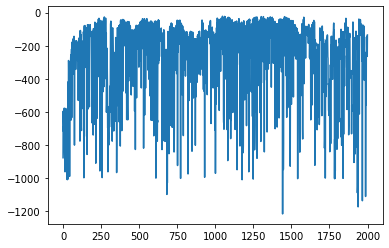

In [5]:
chosen_params = {
    'learning_rate_actor': 1e-4, 
    'learning_rate_critic': 2e-4,
    'tau': 0.001,
    'noise_std':[0.02, 0.01]
}

a,b = 0.01, 0.06

with tf.device('/cpu:0'):
    env = Dubin(cost = lambda x : cost1(*x, a, b))
    state = env.reset()
    done = False
    agent = DDPG(env.observation_space.intervals.shape[0], 2, upper_bounds=env.action_space.high_low()[1], n_layer1=64, n_layer2=64, batch_size=16, **chosen_params)

    input_interval = Interval(interval=[[2, 2], [2, 2], [0, 0]])
    low, high = input_interval.high_low()

    rewards = train(env, agent, input_interval=input_interval, n_episodes=2000, plot_every=50, plot=True)

plt.plot(rewards)
plt.show()

In [6]:
tf.keras.models.save_model(agent.actor, filepath="./models/dubins_actor_a0.02_b0.06_std001_true.tf", save_format="tf")

INFO:tensorflow:Assets written to: ./models/dubins_actor_a0.02_b0.06_std001_true.tf\assets


In [5]:


params = {
    'learning_rate_actor': [1e-4, 1e-5], 
    'learning_rate_critic': [2e-4, 2e-5],
    'tau':[0.005, 0.001],
    'noise_std':[0.01, 0.05, 0.1, 0.3, 0.5],
}

a_low, a_high = 0, 0.1
b_low, b_high = 0, 0.1

with tf.device('/cpu:0'):

    scores = {}

    for i in range(100):
        chosen_params = {}
        for key in params.keys():
            chosen_params[key] = np.random.choice(params[key])
            if key == 'noise_std':
                chosen_params['noise_std'] = [np.random.choice(params[key]), np.random.choice(params[key])]
                a, b = np.random.uniform(a_low, a_high), np.random.uniform(b_low, b_high)
        print(chosen_params, a, b)
        env = Dubin(cost = lambda x : cost1(*x, a, b))
        state = env.reset()
        done = False
        agent = DDPG(env.observation_space.intervals.shape[0], 2, upper_bounds=env.action_space.high_low()[1], n_layer1=64, n_layer2=64, batch_size=16, **chosen_params)
        chosen_params['a'] = a
        chosen_params['b'] = b
        input_interval = Interval(interval=[[2, 2], [2, 2], [0, 0]])
        low, high = input_interval.high_low()

        train_rewards = []
        for j in range(40):
            train_rewards.append(train(env, agent, input_interval=input_interval, n_episodes=1, plot=False))
        
        scores[str(chosen_params)] = train_rewards

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.01]} 0.021193275740434916 0.023774619702470936
[2. 2. 0.]
0.9960406571130687
0.9960406571130687
Episode 0 finished with reward: -630.9578857421875, average reward -630.9578857421875
[2. 2. 0.]
0.10263995520525881
0.10263995520525881
Episode 0 finished with reward: -801.4813232421875, average reward -801.4813232421875
[2. 2. 0.]
-0.600235913597448
-0.600235913597448
Episode 0 finished with reward: -756.3090209960938, average reward -756.3090209960938
[2. 2. 0.]
2.9005170963684828
2.9005170963684828
Episode 0 finished with reward: -711.8897705078125, average reward -711.8897705078125
[2. 2. 0.]
3.8533336491597563
3.8533336491597563
Episode 0 finished with reward: -1116.5899658203125, average reward -1116.5899658203125
[2. 2. 0.]
3.480683173333298
3.480683173333298
Episode 0 finished with reward: -1109.60009765625, average reward -1109.60009765625
[2. 2. 0.]
-0.23900556558638542
-0.239005565

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.01], 'a': 0.021193275740434916, 'b': 0.023774619702470936}


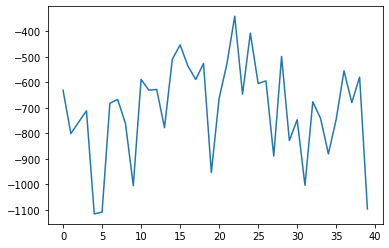

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 0.02445951054222676, 'b': 0.04096957863853204}


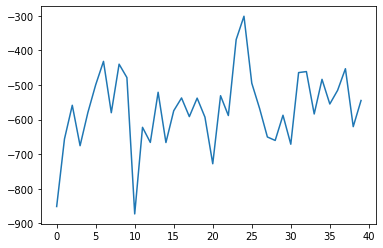

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.3], 'a': 0.034075482169384566, 'b': 0.0018285110592351494}


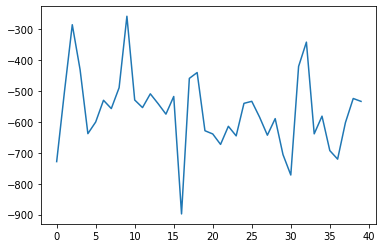

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.05], 'a': 0.023777213140916676, 'b': 0.06504107373013317}


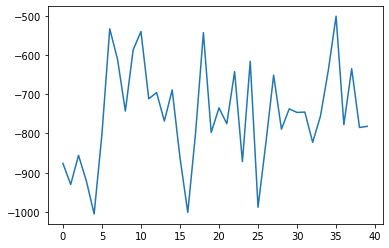

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.05, 0.01], 'a': 0.040032034401519104, 'b': 0.05566435100657194}


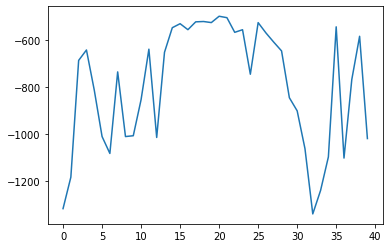

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.5], 'a': 0.07068279655640197, 'b': 0.07393094390234482}


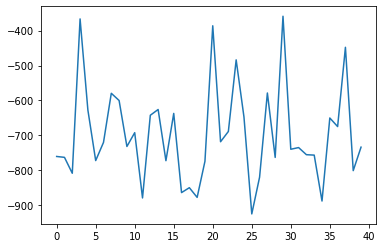

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.3], 'a': 0.004650999502467246, 'b': 0.047016357508001774}


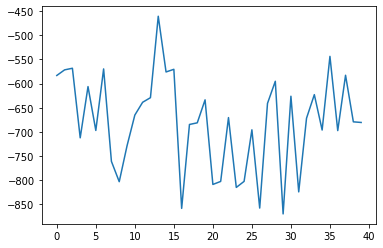

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.05, 0.1], 'a': 0.07840086214107812, 'b': 0.027211497441593083}


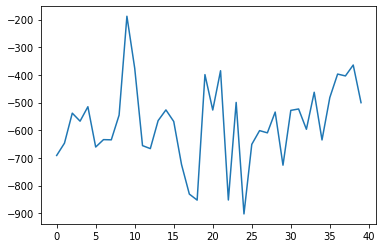

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.1], 'a': 0.02094247862285538, 'b': 0.09234572228247961}


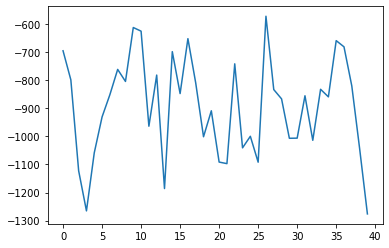

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.5], 'a': 0.08547809379054148, 'b': 0.01674136736318198}


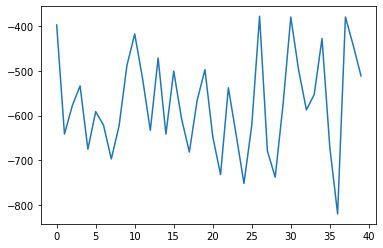

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.3], 'a': 0.08016101352195926, 'b': 0.025748441150324}


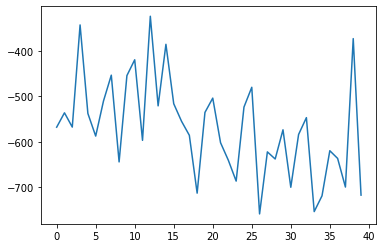

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.3], 'a': 0.027164353583736513, 'b': 0.052554124332805166}


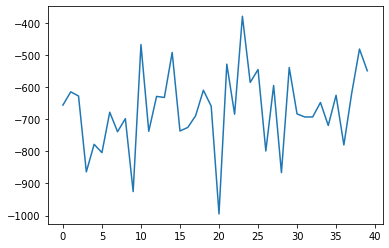

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.5], 'a': 0.04034066300988838, 'b': 0.007505040971524679}


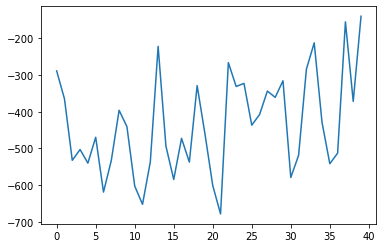

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.5, 0.5], 'a': 0.0018102618090003577, 'b': 0.08261912633137274}


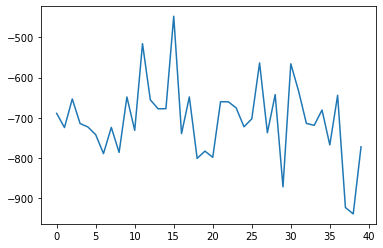

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.01], 'a': 0.013094445052989812, 'b': 0.08017259294434685}


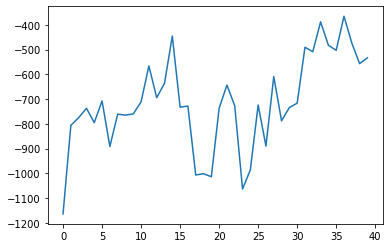

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.3, 0.3], 'a': 0.07780513802797086, 'b': 0.03495344773940715}


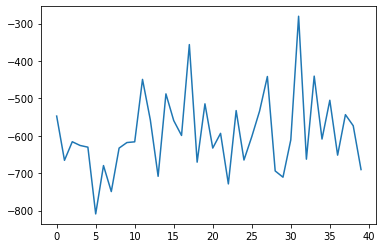

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.3], 'a': 0.050712972821160156, 'b': 0.025691468145242383}


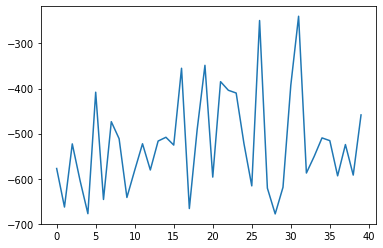

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.01], 'a': 0.08315656957945818, 'b': 0.09985134046546856}


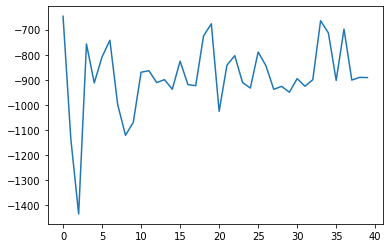

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.01], 'a': 0.021594852800515197, 'b': 0.06161415025808206}


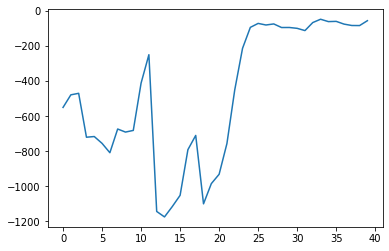

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.05], 'a': 0.09698289493163498, 'b': 0.08759081762568251}


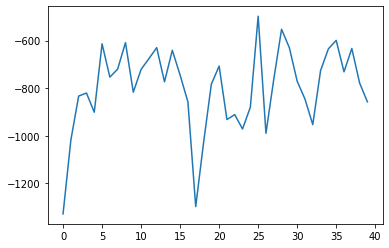

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.01], 'a': 0.009500125563379813, 'b': 0.09522872365574042}


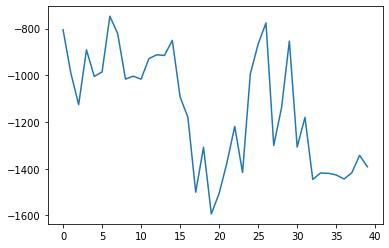

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.01], 'a': 0.04823285926794621, 'b': 0.008603048270119673}


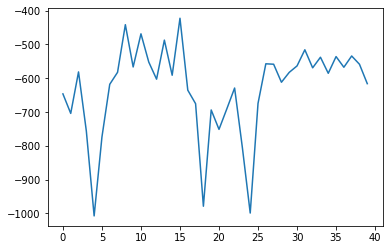

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.5], 'a': 0.07330502541697588, 'b': 0.05494197944217404}


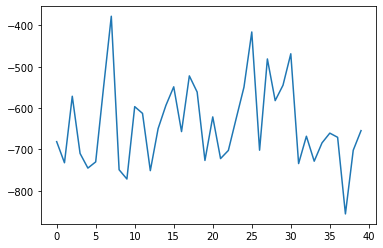

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.5], 'a': 0.0538642922647643, 'b': 0.07485558696522188}


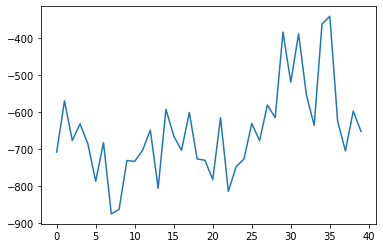

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.1], 'a': 0.06177140364894049, 'b': 0.016982397061162526}


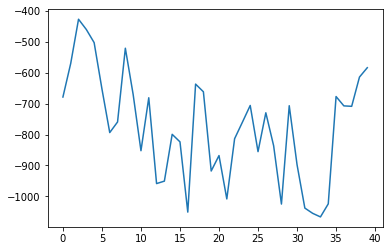

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.05], 'a': 0.05684453744255315, 'b': 0.01813735954903467}


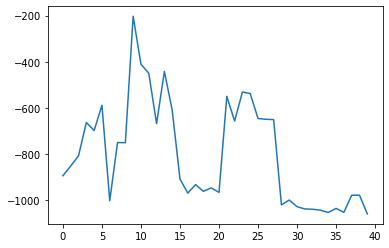

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.05], 'a': 0.048334285651702315, 'b': 0.005390831414756759}


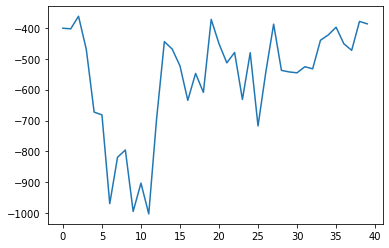

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.01], 'a': 0.01988345809482909, 'b': 0.005084063424121966}


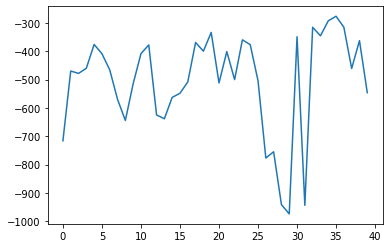

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.5], 'a': 0.06900721606498196, 'b': 0.04884196024671516}


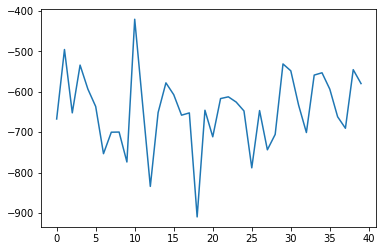

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.05], 'a': 0.09777574256184726, 'b': 0.037405405498221724}


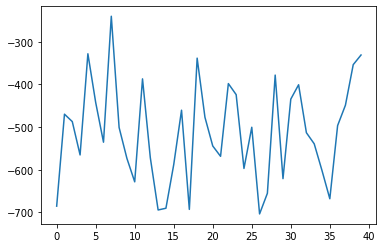

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.01], 'a': 0.06922417158050619, 'b': 0.0021241635243935855}


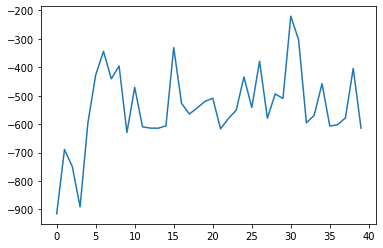

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 0.06211356401938867, 'b': 0.09860589396198098}


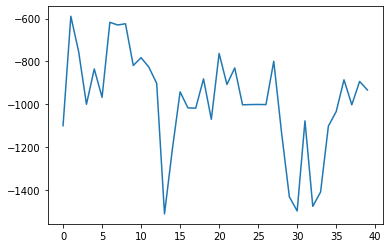

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.01], 'a': 0.010795863276868368, 'b': 0.04343524022864183}


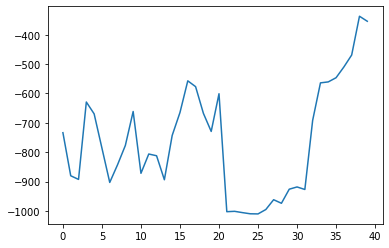

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 0.048832927169789576, 'b': 0.010041071008166803}


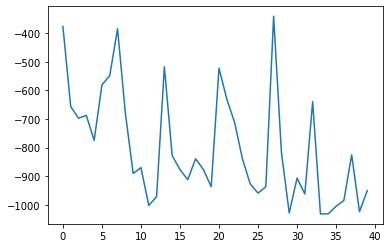

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.5], 'a': 0.05129314657859925, 'b': 0.05531222064041137}


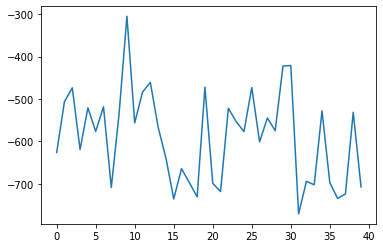

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.3], 'a': 0.012139413196552996, 'b': 0.06194989851695115}


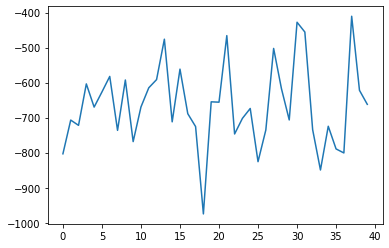

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.5], 'a': 0.06289492435321241, 'b': 0.01858357280358023}


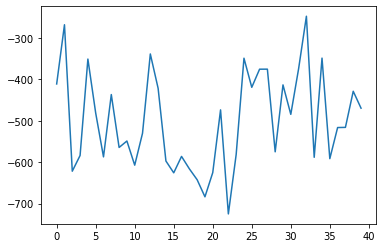

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.05], 'a': 0.01746661644753016, 'b': 0.012759812842326268}


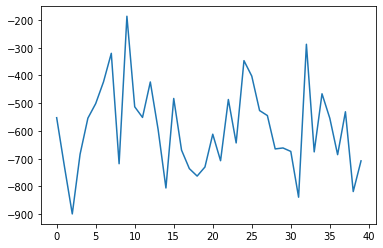

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.5], 'a': 0.024684369673093034, 'b': 0.0396877004787794}


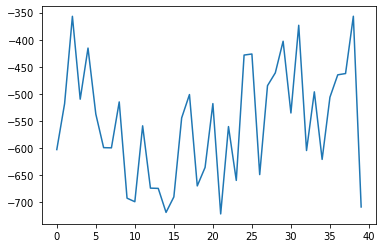

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.05, 0.01], 'a': 0.009807175044438688, 'b': 0.06576798138267685}


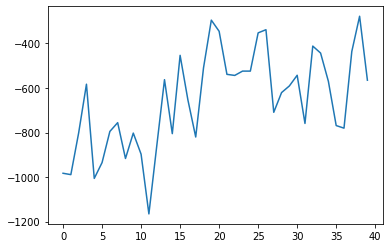

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.01, 0.3], 'a': 0.04654225292907208, 'b': 0.006835339257217921}


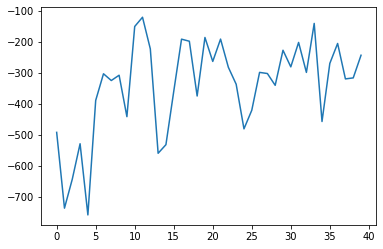

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.5], 'a': 0.09265232490620628, 'b': 0.06788457707884886}


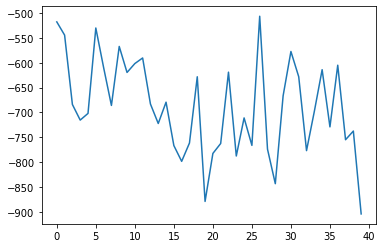

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 0.02842542934449325, 'b': 0.03287593303748704}


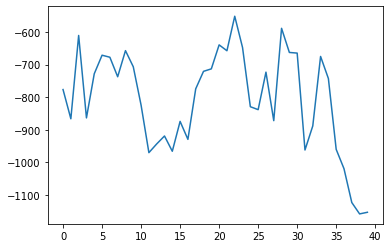

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.5], 'a': 0.030555680133267607, 'b': 0.05615704688585406}


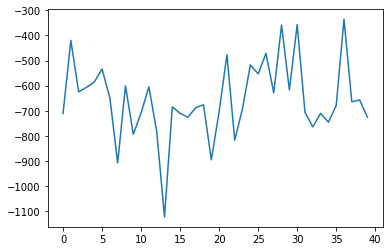

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.3], 'a': 0.06396573684111079, 'b': 0.08197911111948579}


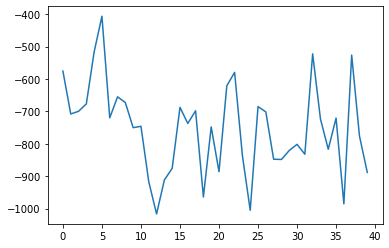

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.05, 0.5], 'a': 0.08911937202200047, 'b': 0.02225405042804879}


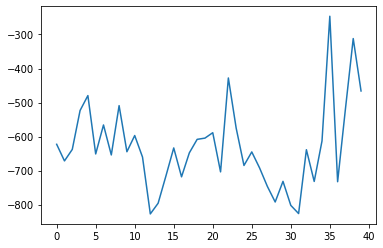

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.5], 'a': 0.058840227992155325, 'b': 0.024041727545159763}


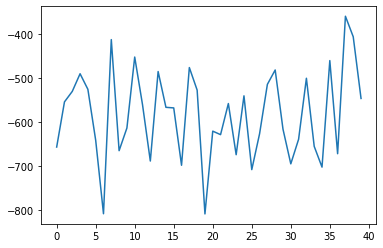

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.05], 'a': 0.03041522762993172, 'b': 0.010382848853011939}


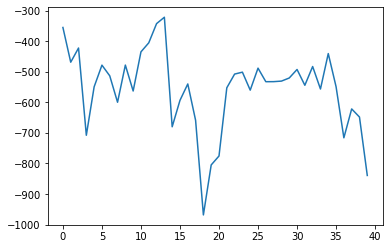

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.5], 'a': 0.09781200644922368, 'b': 0.01910537952527751}


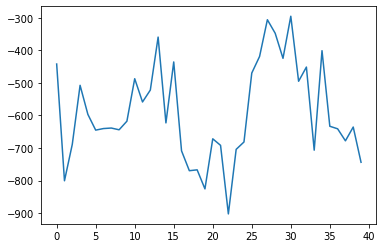

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.5], 'a': 0.09945850489562079, 'b': 0.08329924082846295}


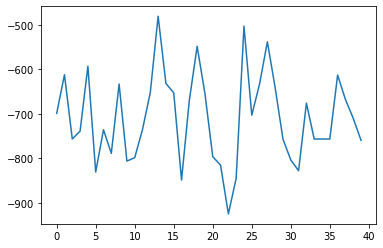

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.1], 'a': 0.0646665605203976, 'b': 0.08665867315419548}


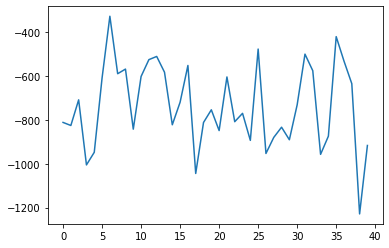

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.01], 'a': 0.04696238982525528, 'b': 0.0960783714296529}


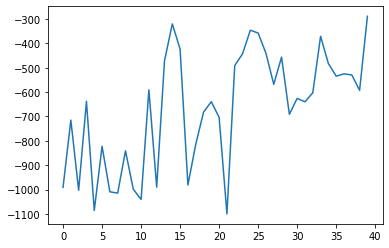

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.1], 'a': 0.09775190269481096, 'b': 0.02812346858557302}


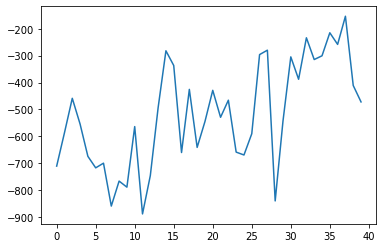

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.05, 0.05], 'a': 0.055155331389375166, 'b': 0.014907559421196327}


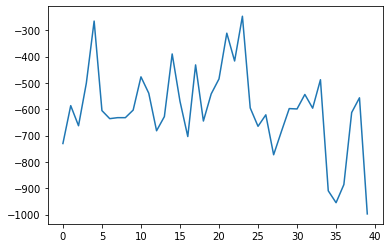

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.1], 'a': 0.03918704883063023, 'b': 0.03920042380681976}


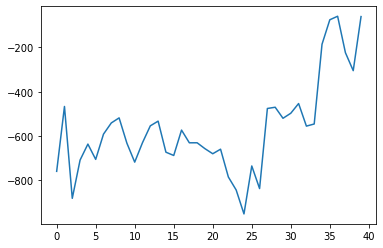

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.3], 'a': 0.07385953586990403, 'b': 0.08482982079354193}


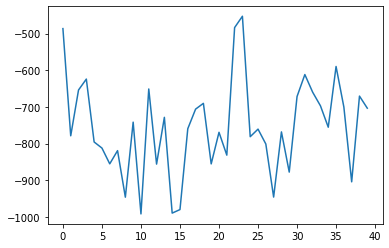

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.05, 0.01], 'a': 0.028110116526277085, 'b': 0.09724516209950158}


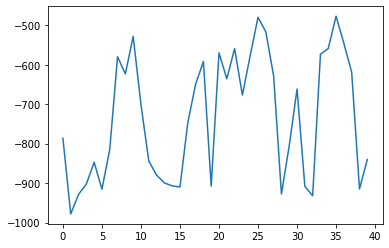

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.3, 0.1], 'a': 0.0258856872154819, 'b': 0.07842017723987968}


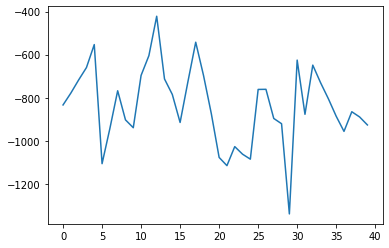

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.05, 0.3], 'a': 0.012762607515698866, 'b': 0.02539827717065093}


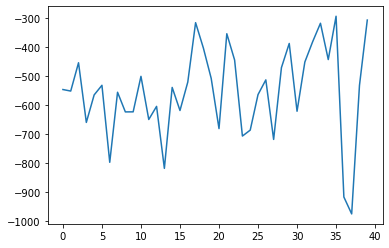

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.05, 0.1], 'a': 0.024781518944913372, 'b': 0.05919351967509452}


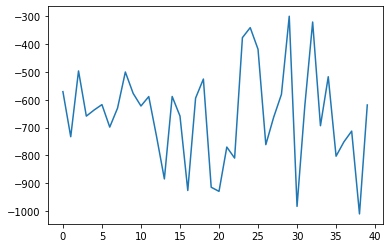

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.1], 'a': 0.021705103217064925, 'b': 0.042171118457645075}


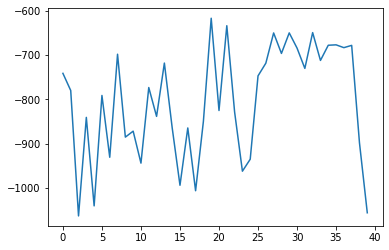

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.01], 'a': 0.021116790044318823, 'b': 0.06705453916764093}


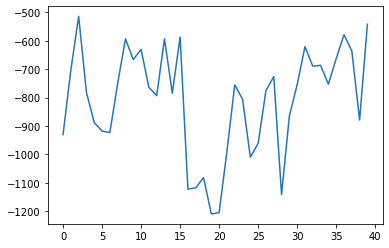

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.01, 0.1], 'a': 0.07200424508497885, 'b': 0.09968768495918781}


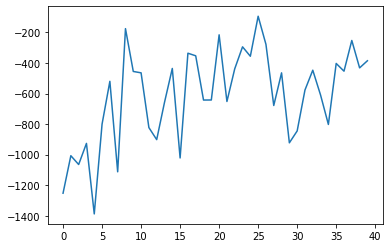

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.01], 'a': 0.06462971902621047, 'b': 0.06887533379499687}


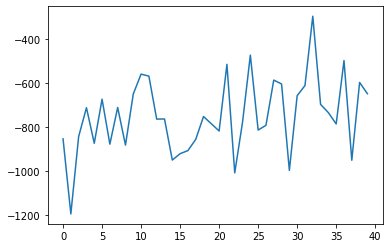

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.05, 0.01], 'a': 0.09410759972193092, 'b': 0.04092368591992293}


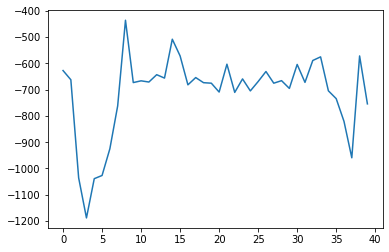

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.01], 'a': 0.0717175966031693, 'b': 0.08442707021719657}


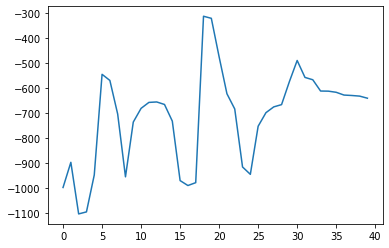

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.1], 'a': 0.07931682855990596, 'b': 0.08221416289881198}


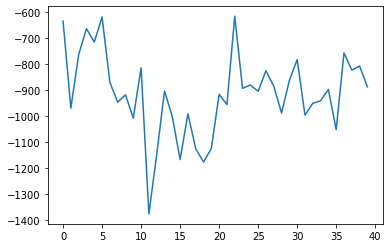

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.1], 'a': 0.05008684042701214, 'b': 0.05119802840915094}


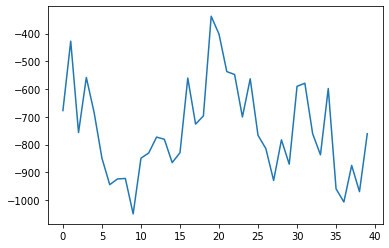

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.01], 'a': 0.049945533287662575, 'b': 0.012908663711314418}


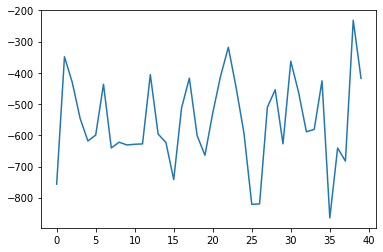

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.3, 0.3], 'a': 0.03593820795231705, 'b': 0.03925042124230759}


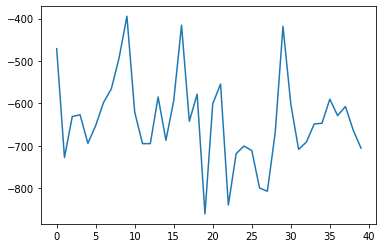

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.5], 'a': 0.028587264874157484, 'b': 0.0472551523800974}


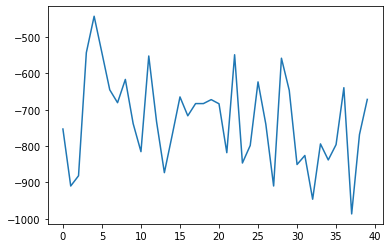

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.05], 'a': 0.08760238135536617, 'b': 0.07702767411862227}


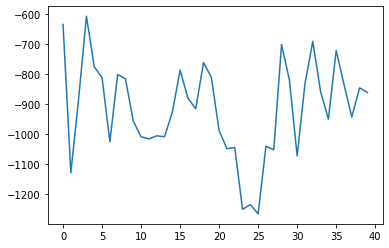

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.5], 'a': 0.06834584762923081, 'b': 0.015304240594658092}


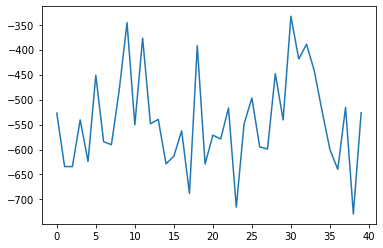

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.05], 'a': 0.06583525132979272, 'b': 0.07717710756507579}


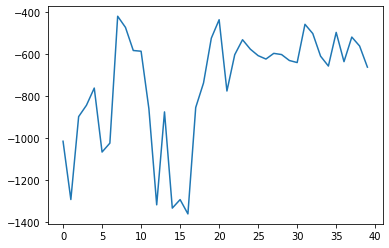

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.1], 'a': 0.07701651174522563, 'b': 0.043925152673494096}


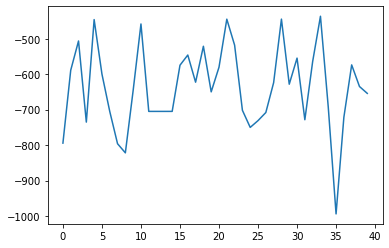

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.05], 'a': 0.08588586499062936, 'b': 0.05625173755488118}


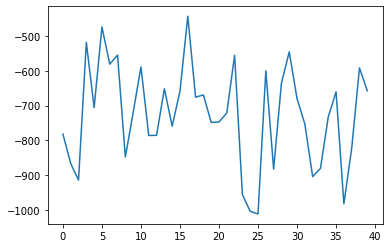

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.5], 'a': 0.09675382846993771, 'b': 0.04943582367674391}


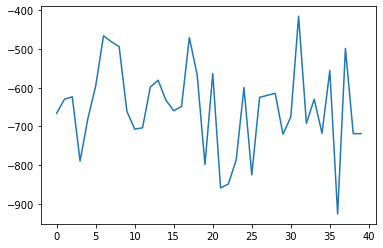

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.5], 'a': 0.06365034336673762, 'b': 0.054656154342188346}


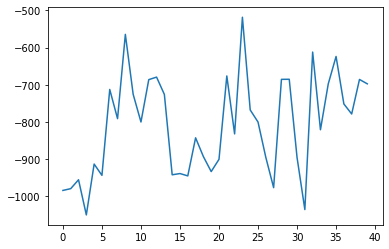

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.01, 0.05], 'a': 0.03616811846684255, 'b': 0.0013724374192966794}


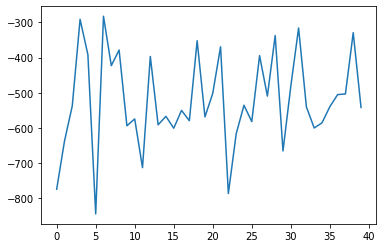

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.3], 'a': 0.05180130433899294, 'b': 0.026506004951808316}


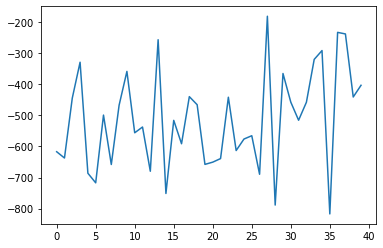

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.5], 'a': 0.0925560453492253, 'b': 0.005131825176740901}


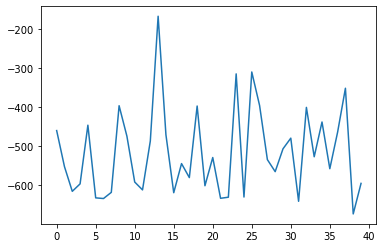

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 0.0015855698330965674, 'b': 0.056062322169580875}


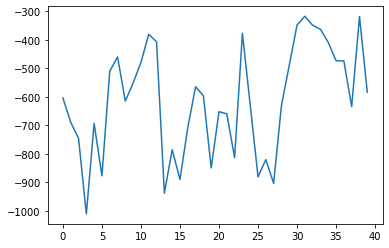

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.01, 0.1], 'a': 0.035827515493598076, 'b': 0.07951694119346694}


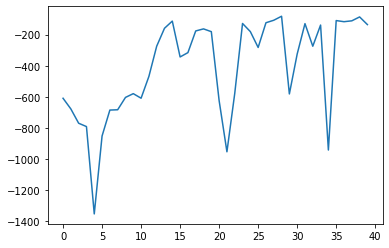

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.1], 'a': 0.08910389616816057, 'b': 0.01873169023078033}


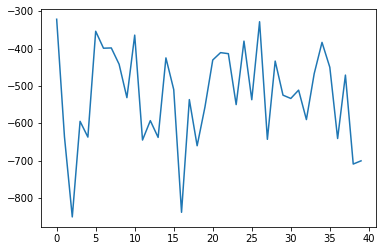

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.05], 'a': 0.019598479674695392, 'b': 0.09064665311822274}


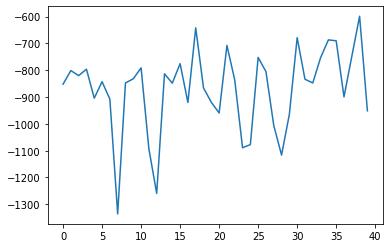

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.3, 0.5], 'a': 0.09272327098997046, 'b': 0.031426816636439724}


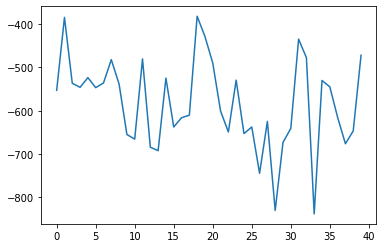

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.3], 'a': 0.09370122283114576, 'b': 0.04402177765064855}


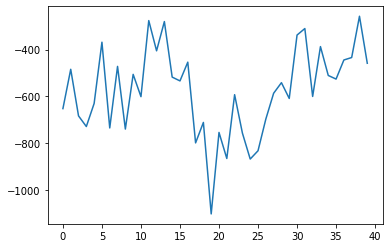

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.05, 0.3], 'a': 0.023877678211671784, 'b': 0.07664406998532104}


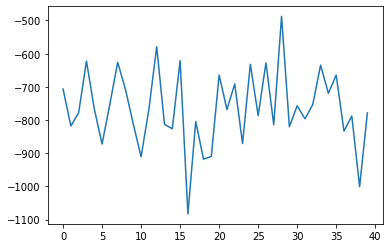

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.05], 'a': 0.08174536071989161, 'b': 0.00505297250836414}


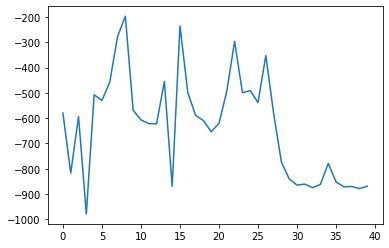

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.05], 'a': 0.018352202973186748, 'b': 0.08863422453401693}


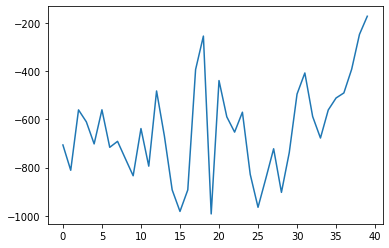

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.05, 0.01], 'a': 0.05708537007189179, 'b': 0.058061240763122635}


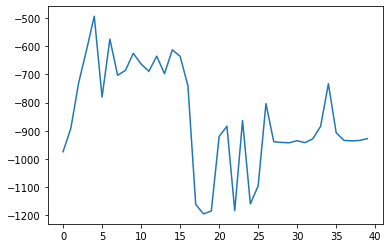

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.05], 'a': 0.006739919670433348, 'b': 0.006465966789696665}


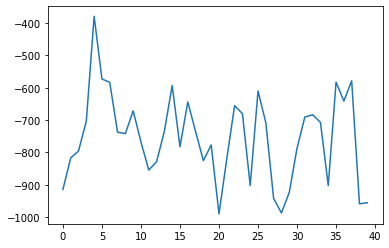

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.1], 'a': 0.035957318788279215, 'b': 0.05640845327897712}


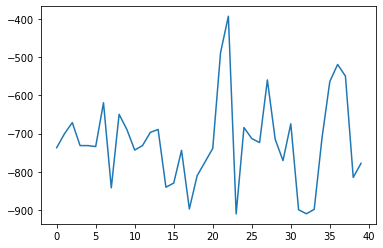

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.5], 'a': 0.015081573730132592, 'b': 0.028380393974069495}


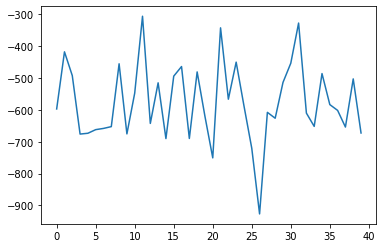

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.01], 'a': 0.07772539163934472, 'b': 0.06775249295456104}


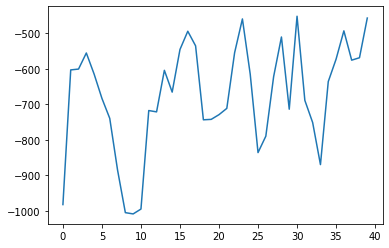

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.1], 'a': 0.059403979331617424, 'b': 0.009679160374152285}


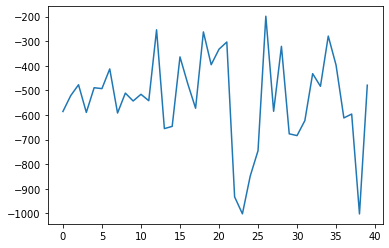

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.5], 'a': 0.05616130508006463, 'b': 0.007875171447312779}


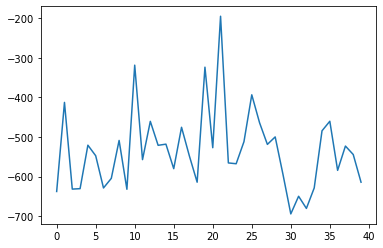

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.5], 'a': 0.08137678370777729, 'b': 0.038179609722889696}


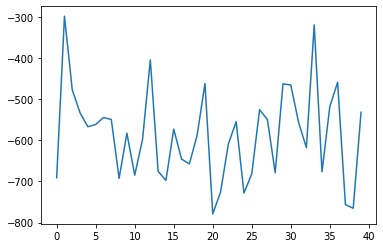

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.05], 'a': 0.04876613095594904, 'b': 0.0634600254609144}


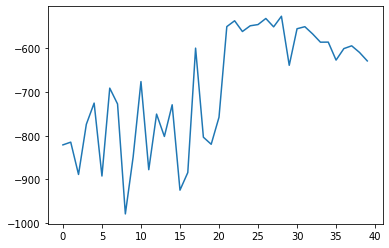

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.01], 'a': 0.08828282618966454, 'b': 0.07517217249027175}


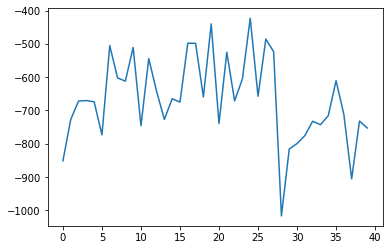

In [6]:
for key, item in scores.items():
    print(key)
    plt.plot(item)
    plt.show()

In [6]:
a,b = 0.02, 0.06
env = Dubin(cost = lambda x : cost1(*x, a, b))
actor = tf.keras.models.load_model(filepath="./models/dubins_actor_a0.02_b0.06_std001_true.tf")
input_interval = Interval(interval=[[2, 2], [2, 2], [0, 0]])
eps_rewards, observations, actions = play(env, actor, n_games= 2, input_interval=input_interval, plot=False, watch=False)

[2. 2. 0.]
1.4936815713976843
1.4936815713976843
Episode 0 finished with reward: -167.6997833251953
[2. 2. 0.]
1.4936815713976843
1.4936815713976843
Episode 1 finished with reward: -167.6997833251953


In [6]:
actor([[0, 0, 0]])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.0499999 , -0.19982211]], dtype=float32)>

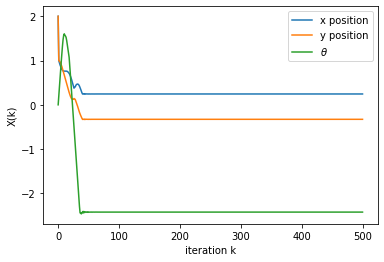

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(observations[0])[:, 0], label="x position")
plt.plot(np.array(observations[0])[:, 1], label="y position")
plt.plot(np.array(observations[0])[:, 2], label=r"$\theta$")
plt.ylabel("X(k)")
plt.xlabel("iteration k")
plt.legend()
plt.show()

In [ ]:
observations[10]

[array([2., 2., 0.], dtype=float32),
 array([ 0.5316863,  2.       , -1.036303 ], dtype=float32),
 array([ 0.59702015,  1.8896329 , -2.4476151 ], dtype=float32),
 array([-0.8059858 ,  0.72226906,  2.3406076 ], dtype=float32),
 array([ 0.5860138, -0.7138149,  1.8527681], dtype=float32),
 array([ 1.1420485, -2.6332252,  2.488728 ], dtype=float32),
 array([ 2.1995776, -3.4419541,  2.7978926], dtype=float32),
 array([ 0.38015297, -2.7907724 , -2.9543455 ], dtype=float32),
 array([ 2.3322213, -2.4209204, -2.2481961], dtype=float32),
 array([ 3.5810652, -0.8683461, -1.103149 ], dtype=float32),
 array([ 2.7094514,  0.857589 , -1.7294508], dtype=float32),
 array([ 2.9861379 ,  2.5868864 , -0.53444684], dtype=float32),
 array([ 2.5217843,  2.86174  , -2.166434 ], dtype=float32),
 array([ 1.8015221,  1.7990175, -2.8610733], dtype=float32),
 array([ 0.5860166,  1.4488102, -2.6726775], dtype=float32),
 array([-0.91191566,  0.6899551 ,  2.3388193 ], dtype=float32),
 array([ 0.47751334, -0.74861604,